In [46]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
sys.dont_write_bytecode = True
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hardcoded performance behavior of different models. The columns are batchsize, p99 latency in ms, and throughput in qps

In [47]:
resnet_array = np.array([
       [1,  132.54010, 10.0],
       [2,  134.24957, 19.7],
       [4,  138.39000, 38.6],
       [8,  149.21285, 76.1],
       [12, 152.38963, 105.2],
       [16, 172.64560, 126.2],
       [24, 212.01610, 168.9],
       [32, 256.63817, 191.5]])
inception_array=resnet_array[np.argsort(resnet_array[:,0])]
inception_array = np.array([
       [1,  68.10305,  26.3],
       [2,  72.8235,   45.8],
       [4,  73.88426,  81.5],
       [8,  105.866700, 132.8],
       [12, 112.031640, 179.5],
       [16, 149.952640, 199.5],
       [24, 195.421250, 213.0]])
inception_array=inception_array[np.argsort(inception_array[:,0])]
ksvm_array = np.array([
       [1, 45.305130, 42.3],
       [2, 45.864000, 74.300000],
       [4, 51.040710, 138.40000],
       [8, 54.351710, 276.90000],
       [12, 59.511130, 390.00000],
       [16, 65.195470, 498.70000],
       [24, 75.762700, 655.50000],
       [48, 93.624520, 811.50000],
       [64, 124.36674, 907.80000]])
ksvm_array=ksvm_array[np.argsort(ksvm_array[:,0])]
logreg_array = np.array([
       [1, 29.28447, 531.5000],
       [2, 30.27719, 608.6000],
       [4, 31.97647, 1038.900],
       [8, 36.15806, 1094.800]])

### A function to create a x and y points and create a function that represents the segement connection between them

In [167]:
def line_segment_function(x,y):
    def result(x_point):
        assert x_point <= max(x) and x_point >= min(x), "{} out of range of {}".format(x_point, x)
        if x_point in x:
            return y[x == x_point][0]
        less_index = max(np.arange(len(x))[x < x_point])
        more_index = min(np.arange(len(x))[x > x_point])
        rise = y[more_index] - y[less_index]
        run = x[more_index] - x[less_index]
        slope = float(rise)/run
        delta = x_point - x[less_index]
        return y[less_index] + delta*slope
    return result

### A graph representation using nodes as well as a scheduler for simulation purposes

In [168]:
class Scheduler(object):
    # Needed for large values, because np.isclose works on a relative scale. 
    # It'll think that 300000.4 is close to 300000.2 because of the large size of the numbers relative to their difference
    def isclose(self, a, b):
        return np.isclose(a-b, 0)
    
    def __init__(self):
        self.time = 0
        self.scheduled = [] # A list of items scheduled to run, from earliest to latest
    
    # Called by the nodes to schedule fn(time_when_fn_executes) to run in_how_long
    # Adds the function in its schedule time position relative to other scheduled function
    def schedule(self, fn, in_how_long, extra_args = []):
        index = 0
        current_time_to_schedule = self.time + in_how_long
        for item_scheduled_time,_,_ in self.scheduled:
             if item_scheduled_time < current_time_to_schedule:
                index+=1
        self.scheduled.insert(index, [current_time_to_schedule, fn, extra_args])
    
    # continues to pop scheduled functions from the front of the queue until the queue is empty
    # Notice how during execution of the tasks already in the queue more tasks can be scheduled
    def start(self):
        while self.scheduled != []:
            next_event_time, fn, extra_args = self.scheduled.pop(0)
            self.time = next_event_time
            fn(self.time, *extra_args)
            while self.scheduled != [] and self.isclose(self.scheduled[0][0], self.time):
                next_event_time, fn, extra_args = self.scheduled.pop(0)
                fn(self.time, *extra_args)

# Abstract Node class.
class Node(object):
    def __init__(self, name, scheduler):
        self.children = []
        self.parents = []
        self.name = name
        self.scheduler = scheduler
    
    def then(self, child):
        self.children.append(child)
        child.parents.append(self)
    
    def __str__(self):
        return self.name+" Node"
    
    def __repr__(self):
        return self.name+" Node"

# Initialized by taking a query history and a scheduler
# Notice how the queries are actually just dictionary lineages of the node-to-node travel
class SourceNode(Node):
    def __init__(self, deltas, scheduler):
        Node.__init__(self, "source", scheduler)
        self.deltas = deltas
        self.deltas_index = 0
        # Schedule the first query to send
        self.scheduler.schedule(self.send_query, 0)
    
    def send_query(self, time):
        for child in self.children:
            self.scheduler.schedule(child.arrival, 0, extra_args=[[{"id":self.deltas_index, "source":time}]])
        if self.deltas_index < len(self.deltas):
            self.scheduler.schedule(self.send_query, self.deltas[self.deltas_index])
            self.deltas_index+=1

# A regular model node, with a dynamic, greedy batchsize selection scheme (minimum of maximum batchsize and queue size)
# batchsize_p99lat_thru argument is the model-profile array like the one shown in the begining of the notebook
# batching_delay argument dictates how long the model waits from the point that it is idle and receives some query that wakes it up to the point that it actually 
# locks and takes a batchsize from the queue. The reason it was introduced is because longer batching_delay means a more uniform batchsize distribution.
class BatchedNode(Node):
    def __init__(self, max_batch_size, batchsize_p99lat_thru, name, scheduler, num_replicas=1, batching_delay=0):
        Node.__init__(self, name, scheduler)
        self.max_batch_size = max_batch_size
        self.batchsize_p99lat_thru = batchsize_p99lat_thru
        self.smoothed_fn = line_segment_function(batchsize_p99lat_thru[:,0], 1/(batchsize_p99lat_thru[:,2]/1000.))
        self.scheduler = scheduler
        self.batching_delay = batching_delay
        self.queue = []
        self.queue_size_over_time = []
        self.batch_sizes_over_time = []
        self.num_replicas = num_replicas
        self.in_model = [[] for _ in range(self.num_replicas)]
        self.model_idle = [True for _ in range(self.num_replicas)]
        self.num_arrivals = 1
    
    def arrival(self, time, query_list):
        self.num_arrivals+=1
        for query in query_list:
            query[self.name+"_enqueue_time"] = time
            self.queue_size_over_time.append([time, len(self.queue)])
        self.queue.extend(query_list)
        import math
        # the number of models that might need waking up, equals to the number of maximum batches in the queue, rounding up
        number_to_wake_up = math.ceil(len(self.queue) / float(self.max_batch_size))
        for model_index in range(len(self.model_idle)):
            if self.model_idle[model_index]:
                self.scheduler.schedule(self.model_take, self.batching_delay, extra_args=[model_index])
                self.model_idle[model_index] = False
                number_to_wake_up-=1
            if number_to_wake_up == 0:
                break
            
    def model_take(self, time, model_index):
        assert len(self.queue) > 0
        num_taken_to_process = min(len(self.queue), self.max_batch_size)
        self.in_model[model_index] = self.queue[:num_taken_to_process]
        self.queue = self.queue[num_taken_to_process:] # dequeue from queue
        for query in self.in_model[model_index]:
            query[self.name+"_dequeue_time"] = time
            query[self.name+"_batchsize"] = num_taken_to_process
            query_id = query["id"]
        self.queue_size_over_time.append([time, len(self.queue)])
        self.batch_sizes_over_time.append([time, num_taken_to_process])
        self.scheduler.schedule(self.model_return, self.smoothed_fn(num_taken_to_process), extra_args=[model_index]) # service time of batch
    
    def model_return(self, time, model_index):
        for query in self.in_model[model_index]:
            query[self.name+"_service_time"] = time
        query_batch_copy = list(self.in_model[model_index])
        for child in self.children:
            self.scheduler.schedule(child.arrival, 0, extra_args=[query_batch_copy])
        self.in_model[model_index] = []
        if len(self.queue) == 0:
            self.model_idle[model_index] = True
        else:
            self.scheduler.schedule(self.model_take, self.batching_delay, extra_args=[model_index])

# Waits for queries of the same id to arrive from all the parents before sending the union of the lineages to the children
class JoinNode(Node):
    def __init__(self, scheduler):
        Node.__init__(self, "join", scheduler)
        self.waiting_values = {} # maps from id to list of queries
    
    def union_dicts(self, dict_list):
        if len(dict_list) == 0:
            return {}
        result = {}
        for dict_element in dict_list:
            result = dict(result, **dict_element)
        return result
    
    def arrival(self, time, query_list):
        query_output_list = []
        for query in query_list:
            query_id = query["id"]
            if self.waiting_values.get(query_id) == None:
                self.waiting_values[query_id] = [query]
            else:
                self.waiting_values[query_id].append(query)
            if len(self.waiting_values[query_id]) == len(self.parents):
                query_union = self.union_dicts(self.waiting_values[query_id])
                query_output_list.append(query_union)
        if query_output_list != []:
            for child in self.children:
                self.scheduler.schedule(child.arrival, 0, extra_args=[query_output_list]) 
        
# Prints every 1000 queries that end up in it, the entire lineage at the end is found at self.queue 
class SinkNode(Node):
    def __init__(self, scheduler):
        Node.__init__(self, "sink", scheduler)
        self.queue = []
        self.counter = 0
    
    def arrival(self, time, query_list):
        for query in query_list:
            self.counter+=1
            if self.counter % 1000 == 0:
                print self.counter
            query["sink"] = time
        self.queue.extend(query_list)

### Define Image Driver 1

In [169]:
# shape of image driver 1 graph
# The hardware configuration for each node
# The model behavior for each node
# The arrival history

model_configs = {
    "Inception": {"bs":16, "rf": 1, "hw": "V100"},
    "ResNet":    {"bs":16, "rf": 1, "hw": "V100"},
    "KSVM":      {"bs":16, "rf": 1, "hw": "none"},
    "LogReg":    {"bs":2, "rf": 1, "hw": "none"}
}


# Gives batchsize, p99, throughput array based on hardware placement for each model
# Here it assumes just V100s for GPU models
def model_behaviors_from_configs(model_configs):
    model_behaviors = {
        "Inception":inception_array,
        "ResNet":resnet_array,
        "KSVM":ksvm_array,
        "LogReg":logreg_array
    }
    return model_behaviors

# Returns maximum end-to-end throughput of pipeline (assuming maximum batchsize)
def end_to_end_max_throughput(model_configs, model_behaviors):
    resnet_bs = model_configs["ResNet"]["bs"]
    inception_bs = model_configs["Inception"]["bs"]
    ksvm_bs = model_configs["KSVM"]["bs"]
    logreg_bs = model_configs["LogReg"]["bs"]
    resnet_branch = min(resnet_throughput, ksvm_throughput)
    inception_branch = min(inception_througput, ksvm_throughput)
    return min(resnet_branch, inception_branch)

# Returns minimum end-to-end latency of pipeline (not accounting for queuing effects)
def end_to_end_min_lat(model_configs, model_behaviors):
    pass

def get_end_to_end_times(model_configs, model_behaviors, deltas):
    scheduler = Scheduler()
    source = SourceNode(deltas, scheduler)
    inception = BatchedNode(max_batch_size=model_configs["Inception"]["bs"], 
                            batchsize_p99lat_thru=model_behaviors["Inception"], 
                            name="Inception", scheduler=scheduler, batching_delay=0, 
                            num_replicas=model_configs["Inception"]["rf"]) 
    resnet    = BatchedNode(max_batch_size=model_configs["ResNet"]["bs"], 
                            batchsize_p99lat_thru=model_behaviors["ResNet"], 
                            name="ResNet", scheduler=scheduler, batching_delay=0, 
                            num_replicas=model_configs["ResNet"]["rf"])
    ksvm      = BatchedNode(max_batch_size=model_configs["KSVM"]["bs"], 
                            batchsize_p99lat_thru=model_behaviors["KSVM"], 
                            name="KSVM", scheduler=scheduler, batching_delay=0, 
                            num_replicas=model_configs["KSVM"]["rf"])
    logreg    = BatchedNode(max_batch_size=model_configs["LogReg"]["bs"], 
                            batchsize_p99lat_thru=model_behaviors["LogReg"], 
                            name="LogReg", scheduler=scheduler, batching_delay=0, 
                            num_replicas=model_configs["LogReg"]["rf"])
    join = JoinNode(scheduler)
    sink = SinkNode(scheduler)
    source.then(resnet)
    source.then(inception)
    inception.then(logreg)
    resnet.then(ksvm)
    logreg.then(join)
    ksvm.then(join)
    join.then(sink)
    scheduler.start()
    final_lineage_result = sink.queue
    return final_lineage_result

def check_feasibility(model_configs, model_behaviors, deltas, slo):
    mean_arrival_throughput = 1/np.mean(deltas)*1000 # average arrival throughput in qps
    max_pipeline_throughput = end_to_end_max_throughput(model_configs, model_behaviors) # max throughput in qps
    if mean_arrival_throughput > max_pipeline_throughput:
        return False
    min_pipeline_latency = end_to_end_min_lat(model_configs, model_behaviors)
    if min_pipeline_latency > slo:
        return False
    end_to_end_times = get_end_to_end_times(model_configs, model_behaviors, deltas)
    if np.max(end_to_end_times) > slo:
        return False
    return True

In [170]:
lambd = 100
CV = 4.0
with open("../experiments/cached_arrival_processes/{}_{}.deltas".format(lambd, CV), 'r') as f:
    deltas = np.array([float(l.strip()) for l in f]).flatten()

queue = get_end_to_end_times(model_configs, model_behaviors_from_configs(model_configs), deltas)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


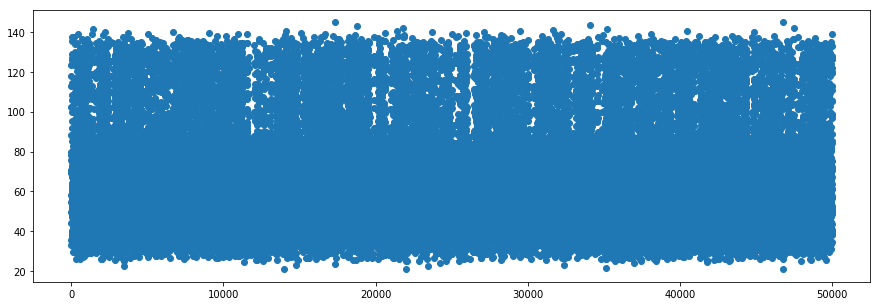

In [140]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(len(queue)), [x["sink"] - x["source"] for x in queue])